In [221]:
import numpy as np   
import pandas as pd    
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sns
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import time

In [222]:
data = pd.read_csv('vehicle.csv')

In [223]:
data.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio class  
0             187.0            197   van  
1             189.0            199   van  
2             188.0            196   car  
3             199.0            207   van  
4             180.0            183   bus

In [224]:
data.shape

(846, 19)

In [225]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 19 columns):
compactness                    846 non-null int64
circularity                    841 non-null float64
distance_circularity           842 non-null float64
radius_ratio                   840 non-null float64
pr.axis_aspect_ratio           844 non-null float64
max.length_aspect_ratio        846 non-null int64
scatter_ratio                  845 non-null float64
elongatedness                  845 non-null float64
pr.axis_rectangularity         843 non-null float64
max.length_rectangularity      846 non-null int64
scaled_variance                843 non-null float64
scaled_variance.1              844 non-null float64
scaled_radius_of_gyration      844 non-null float64
scaled_radius_of_gyration.1    842 non-null float64
skewness_about                 840 non-null float64
skewness_about.1               845 non-null float64
skewness_about.2               845 non-null float64
hollows_ratio    

## Data pre-processing

In [227]:
# Check number of not a number values
data.isna().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [228]:
data[data['radius_ratio'].isna() == True]

compactness  circularity  distance_circularity  radius_ratio  \
9             93         44.0                  98.0           NaN   
78           104         52.0                  94.0           NaN   
159           91         45.0                  75.0           NaN   
287           88         43.0                  84.0           NaN   
345          101         54.0                 106.0           NaN   
467           96         54.0                 104.0           NaN   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
9                    62.0                       11          183.0   
78                   66.0                        5          208.0   
159                  57.0                        6          150.0   
287                  55.0                       11          154.0   
345                  57.0                        7          236.0   
467                  58.0                       10          215.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
9             36.0                    22.0                        146   
78            31.0                    24.0                        161   
159           44.0                    19.0                        146   
287           44.0                    19.0                        150   
345           28.0                    26.0                        164   
467           31.0                    24.0                        175   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
9              202.0              505.0                      152.0   
78             227.0              666.0                      218.0   
159            170.0              335.0                      180.0   
287            174.0              350.0                      164.0   
345            256.0              833.0                      253.0   
467            221.0              682.0                      222.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
9                           64.0             4.0              14.0   
78                          76.0            11.0               4.0   
159                         66.0            16.0               2.0   
287                         73.0             6.0               2.0   
345                         81.0             6.0              14.0   
467                         75.0            13.0              23.0   

     skewness_about.2  hollows_ratio class  
9               195.0            204   car  
78              193.0            191   bus  
159             193.0            198   car  
287             185.0            196   van  
345             185.0            185   bus  
467             186.0            194   car

In [229]:
data['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [230]:
# Creating a copy of dataframe to have class variable with us before operating on NaN values
import copy
data_copy = copy.deepcopy(data)

In [231]:
# Convert class variable to values
from sklearn.preprocessing import LabelEncoder
data_copy["class"] = LabelEncoder().fit_transform(data_copy["class"])
data_copy.head()

compactness  circularity  distance_circularity  radius_ratio  \
0           95         48.0                  83.0         178.0   
1           91         41.0                  84.0         141.0   
2          104         50.0                 106.0         209.0   
3           93         41.0                  82.0         159.0   
4           85         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                       10          162.0   
1                  57.0                        9          149.0   
2                  66.0                       10          207.0   
3                  63.0                        9          144.0   
4                 103.0                       52          149.0   

   elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0           42.0                    20.0                        159   
1           45.0                    19.0                        143   
2           32.0                    23.0                        158   
3           46.0                    19.0                        143   
4           45.0                    19.0                        144   

   scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0            176.0              379.0                      184.0   
1            170.0              330.0                      158.0   
2            223.0              635.0                      220.0   
3            160.0              309.0                      127.0   
4            241.0              325.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0            197      2  
1             189.0            199      2  
2             188.0            196      1  
3             199.0            207      2  
4             180.0            183      0

In [232]:
data_copy.describe().transpose()

count        mean         std    min     25%  \
compactness                  846.0   93.678487    8.234474   73.0   87.00   
circularity                  841.0   44.828775    6.152172   33.0   40.00   
distance_circularity         842.0   82.110451   15.778292   40.0   70.00   
radius_ratio                 840.0  168.888095   33.520198  104.0  141.00   
pr.axis_aspect_ratio         844.0   61.678910    7.891463   47.0   57.00   
max.length_aspect_ratio      846.0    8.567376    4.601217    2.0    7.00   
scatter_ratio                845.0  168.901775   33.214848  112.0  147.00   
elongatedness                845.0   40.933728    7.816186   26.0   33.00   
pr.axis_rectangularity       843.0   20.582444    2.592933   17.0   19.00   
max.length_rectangularity    846.0  147.998818   14.515652  118.0  137.00   
scaled_variance              843.0  188.631079   31.411004  130.0  167.00   
scaled_variance.1            844.0  439.494076  176.666903  184.0  318.00   
scaled_radius_of_gyration    844.0  174.709716   32.584808  109.0  149.00   
scaled_radius_of_gyration.1  842.0   72.447743    7.486190   59.0   67.00   
skewness_about               840.0    6.364286    4.920649    0.0    2.00   
skewness_about.1             845.0   12.602367    8.936081    0.0    5.00   
skewness_about.2             845.0  188.919527    6.155809  176.0  184.00   
hollows_ratio                846.0  195.632388    7.438797  181.0  190.25   
class                        846.0    0.977541    0.702130    0.0    0.00   

                               50%    75%     max  
compactness                   93.0  100.0   119.0  
circularity                   44.0   49.0    59.0  
distance_circularity          80.0   98.0   112.0  
radius_ratio                 167.0  195.0   333.0  
pr.axis_aspect_ratio          61.0   65.0   138.0  
max.length_aspect_ratio        8.0   10.0    55.0  
scatter_ratio                157.0  198.0   265.0  
elongatedness                 43.0   46.0    61.0  
pr.axis_rectangularity        20.0   23.0    29.0  
max.length_rectangularity    146.0  159.0   188.0  
scaled_variance              179.0  217.0   320.0  
scaled_variance.1            363.5  587.0  1018.0  
scaled_radius_of_gyration    173.5  198.0   268.0  
scaled_radius_of_gyration.1   71.5   75.0   135.0  
skewness_about                 6.0    9.0    22.0  
skewness_about.1              11.0   19.0    41.0  
skewness_about.2             188.0  193.0   206.0  
hollows_ratio                197.0  201.0   211.0  
class                          1.0    1.0     2.0

In [127]:
# Observation: as outliers present, replace nan values with median

In [233]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='median')
imputer = imputer.fit(data_copy)
data_copy = pd.DataFrame(np.array(imputer.transform(data_copy)),columns=data_copy.columns)

In [234]:
data_copy

compactness  circularity  distance_circularity  radius_ratio  \
0           95.0         48.0                  83.0         178.0   
1           91.0         41.0                  84.0         141.0   
2          104.0         50.0                 106.0         209.0   
3           93.0         41.0                  82.0         159.0   
4           85.0         44.0                  70.0         205.0   
..           ...          ...                   ...           ...   
841         93.0         39.0                  87.0         183.0   
842         89.0         46.0                  84.0         163.0   
843        106.0         54.0                 101.0         222.0   
844         86.0         36.0                  78.0         146.0   
845         85.0         36.0                  66.0         123.0   

     pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                    72.0                     10.0          162.0   
1                    57.0                      9.0          149.0   
2                    66.0                     10.0          207.0   
3                    63.0                      9.0          144.0   
4                   103.0                     52.0          149.0   
..                    ...                      ...            ...   
841                  64.0                      8.0          169.0   
842                  66.0                     11.0          159.0   
843                  67.0                     12.0          222.0   
844                  58.0                      7.0          135.0   
845                  55.0                      5.0          120.0   

     elongatedness  pr.axis_rectangularity  max.length_rectangularity  \
0             42.0                    20.0                      159.0   
1             45.0                    19.0                      143.0   
2             32.0                    23.0                      158.0   
3             46.0                    19.0                      143.0   
4             45.0                    19.0                      144.0   
..             ...                     ...                        ...   
841           40.0                    20.0                      134.0   
842           43.0                    20.0                      159.0   
843           30.0                    25.0                      173.0   
844           50.0                    18.0                      124.0   
845           56.0                    17.0                      128.0   

     scaled_variance  scaled_variance.1  scaled_radius_of_gyration  \
0              176.0              379.0                      184.0   
1              170.0              330.0                      158.0   
2              223.0              635.0                      220.0   
3              160.0              309.0                      127.0   
4              241.0              325.0                      188.0   
..               ...                ...                        ...   
841            200.0              422.0                      149.0   
842            173.0              368.0                      176.0   
843            228.0              721.0                      200.0   
844            155.0              270.0                      148.0   
845            140.0              212.0                      131.0   

     scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                           70.0             6.0              16.0   
1                           72.0             9.0              14.0   
2                           73.0            14.0               9.0   
3                           63.0             6.0              10.0   
4                          127.0             9.0              11.0   
..                           ...             ...               ...   
841                         72.0             7.0              25.0   
842                         72.0             1.0              20.0   

## Understanding the attributes

In [235]:
# Understanding the attributes - Find relationship between different
# attributes (Independent variables) and choose carefully which all
# attributes have to be a part of the analysis and why

In [236]:
# 2. Relationship between var
data_copy.corr()

compactness  circularity  distance_circularity  \
compactness                     1.000000     0.684887              0.789928   
circularity                     0.684887     1.000000              0.792320   
distance_circularity            0.789928     0.792320              1.000000   
radius_ratio                    0.689743     0.620912              0.767035   
pr.axis_aspect_ratio            0.091534     0.153778              0.158456   
max.length_aspect_ratio         0.148249     0.251467              0.264686   
scatter_ratio                   0.812620     0.847938              0.905076   
elongatedness                  -0.788750    -0.821472             -0.911307   
pr.axis_rectangularity          0.813694     0.843400              0.893025   
max.length_rectangularity       0.676143     0.961318              0.774527   
scaled_variance                 0.762070     0.796306              0.861519   
scaled_variance.1               0.814012     0.835946              0.886017   
scaled_radius_of_gyration       0.585243     0.925816              0.705771   
scaled_radius_of_gyration.1    -0.249593     0.051946             -0.225944   
skewness_about                  0.236078     0.144198              0.113924   
skewness_about.1                0.157015    -0.011439              0.265547   
skewness_about.2                0.298537    -0.104426              0.146098   
hollows_ratio                   0.365552     0.046351              0.332732   
class                          -0.033796    -0.158910             -0.064467   

                             radius_ratio  pr.axis_aspect_ratio  \
compactness                      0.689743              0.091534   
circularity                      0.620912              0.153778   
distance_circularity             0.767035              0.158456   
radius_ratio                     1.000000              0.663447   
pr.axis_aspect_ratio             0.663447              1.000000   
max.length_aspect_ratio          0.450052              0.648724   
scatter_ratio                    0.734429              0.103732   
elongatedness                   -0.789481             -0.183035   
pr.axis_rectangularity           0.708385              0.079604   
max.length_rectangularity        0.568949              0.126909   
scaled_variance                  0.793415              0.272910   
scaled_variance.1                0.718436              0.089189   
scaled_radius_of_gyration        0.536372              0.121971   
scaled_radius_of_gyration.1     -0.180397              0.152950   
skewness_about                   0.048713             -0.058371   
skewness_about.1                 0.173741             -0.031976   
skewness_about.2                 0.382214              0.239886   
hollows_ratio                    0.471309              0.267725   
class                           -0.182186             -0.098178   

                             max.length_aspect_ratio  scatter_ratio  \
compactness                                 0.148249       0.812620   
circularity                                 0.251467       0.847938   
distance_circularity                        0.264686       0.905076   
radius_ratio                                0.450052       0.734429   
pr.axis_aspect_ratio                        0.648724       0.103732   
max.length_aspect_ratio                     1.000000       0.166191   
scatter_ratio                               0.166191       1.000000   
elongatedness                              -0.180140      -0.971601   
pr.axis_rectangularity                      0.161502       0.989751   
max.length_rectangularity                   0.305943       0.809083   
scaled_variance                             0.318957       0.948662   
scaled_variance.1                           0.143253       0.993012   
scaled_radius_of_gyration                   0.189743       0.799875   
scaled_radius_of_gyration.1                 0.295735      -0.027542   
skewness_about                            

([<matplotlib.axis.YTick at 0x7ffad4258c90>,
 <a list of 19 Text yticklabel objects>)

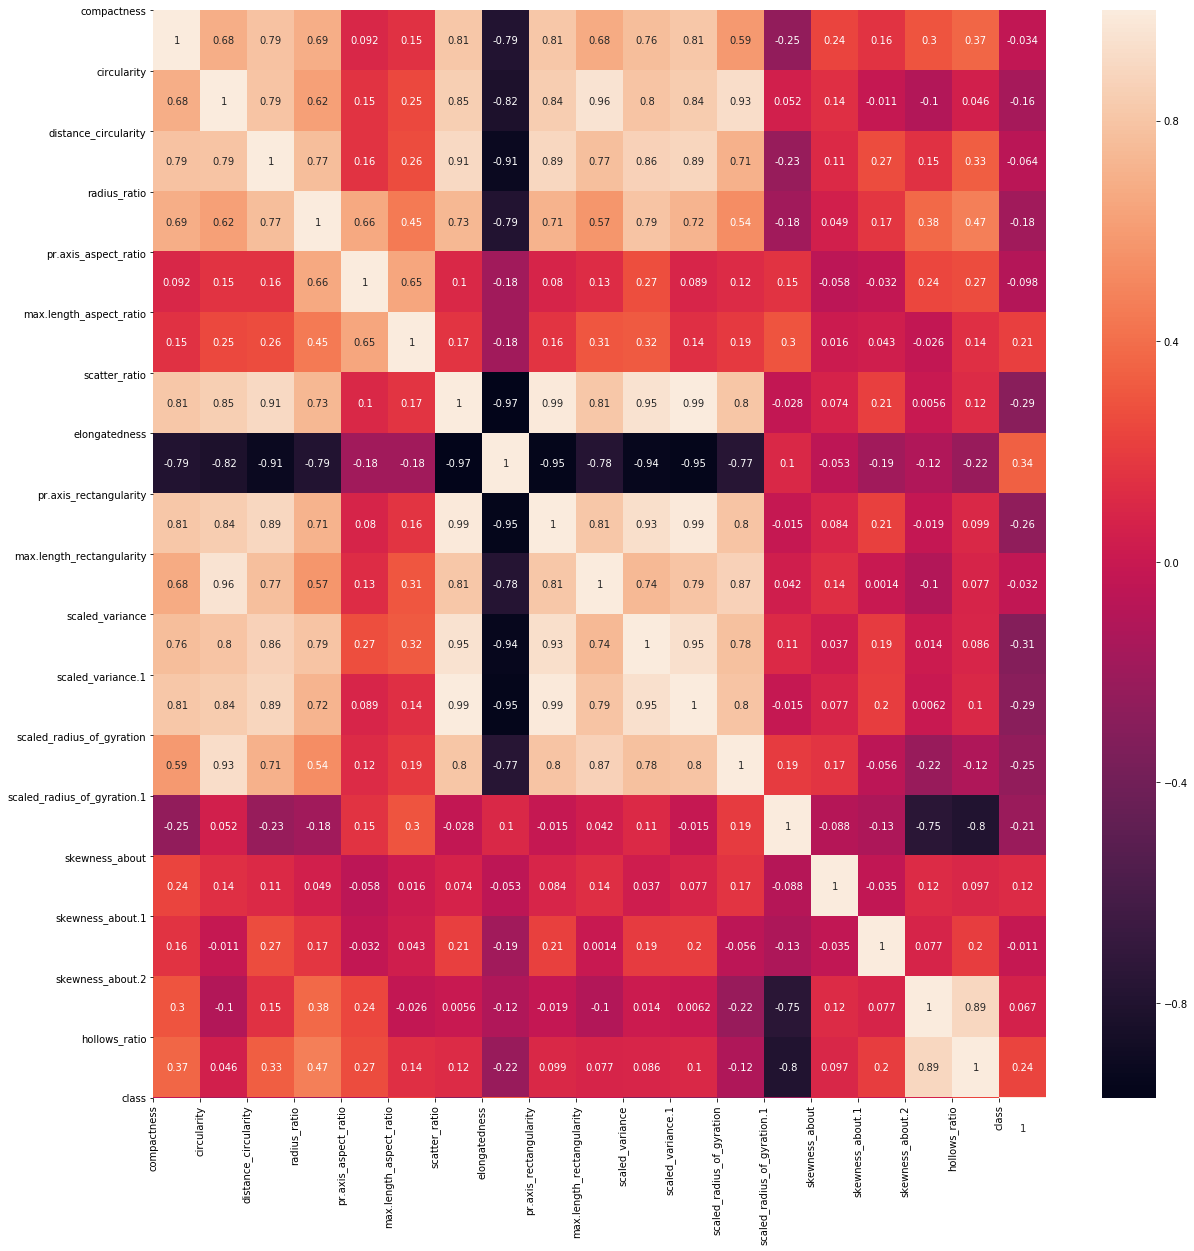

In [237]:
correlation_matrix = data_copy.corr()
fig,ax = plt.subplots(figsize=(20,20)) 
sns.heatmap(correlation_matrix, annot=True, ax=ax)  
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns) 
plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns) 

#### Remove columns if we can 

In [238]:
# For multicollinearity lets remove columns having corr of 95% pr.axis_rectangularity,scaled_variance,scaled_variance.1
# 99 % corelation between scatter_ratio and scaled_variance
# There are Attributes which are directly not related to class but can not remove these columns directly as they can be useful while doing PCA

In [239]:
data_copy.drop(['pr.axis_rectangularity','scaled_variance','scaled_variance.1'],axis=1,inplace=True)

In [240]:
data_copy.shape

(846, 16)

/home/arun/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


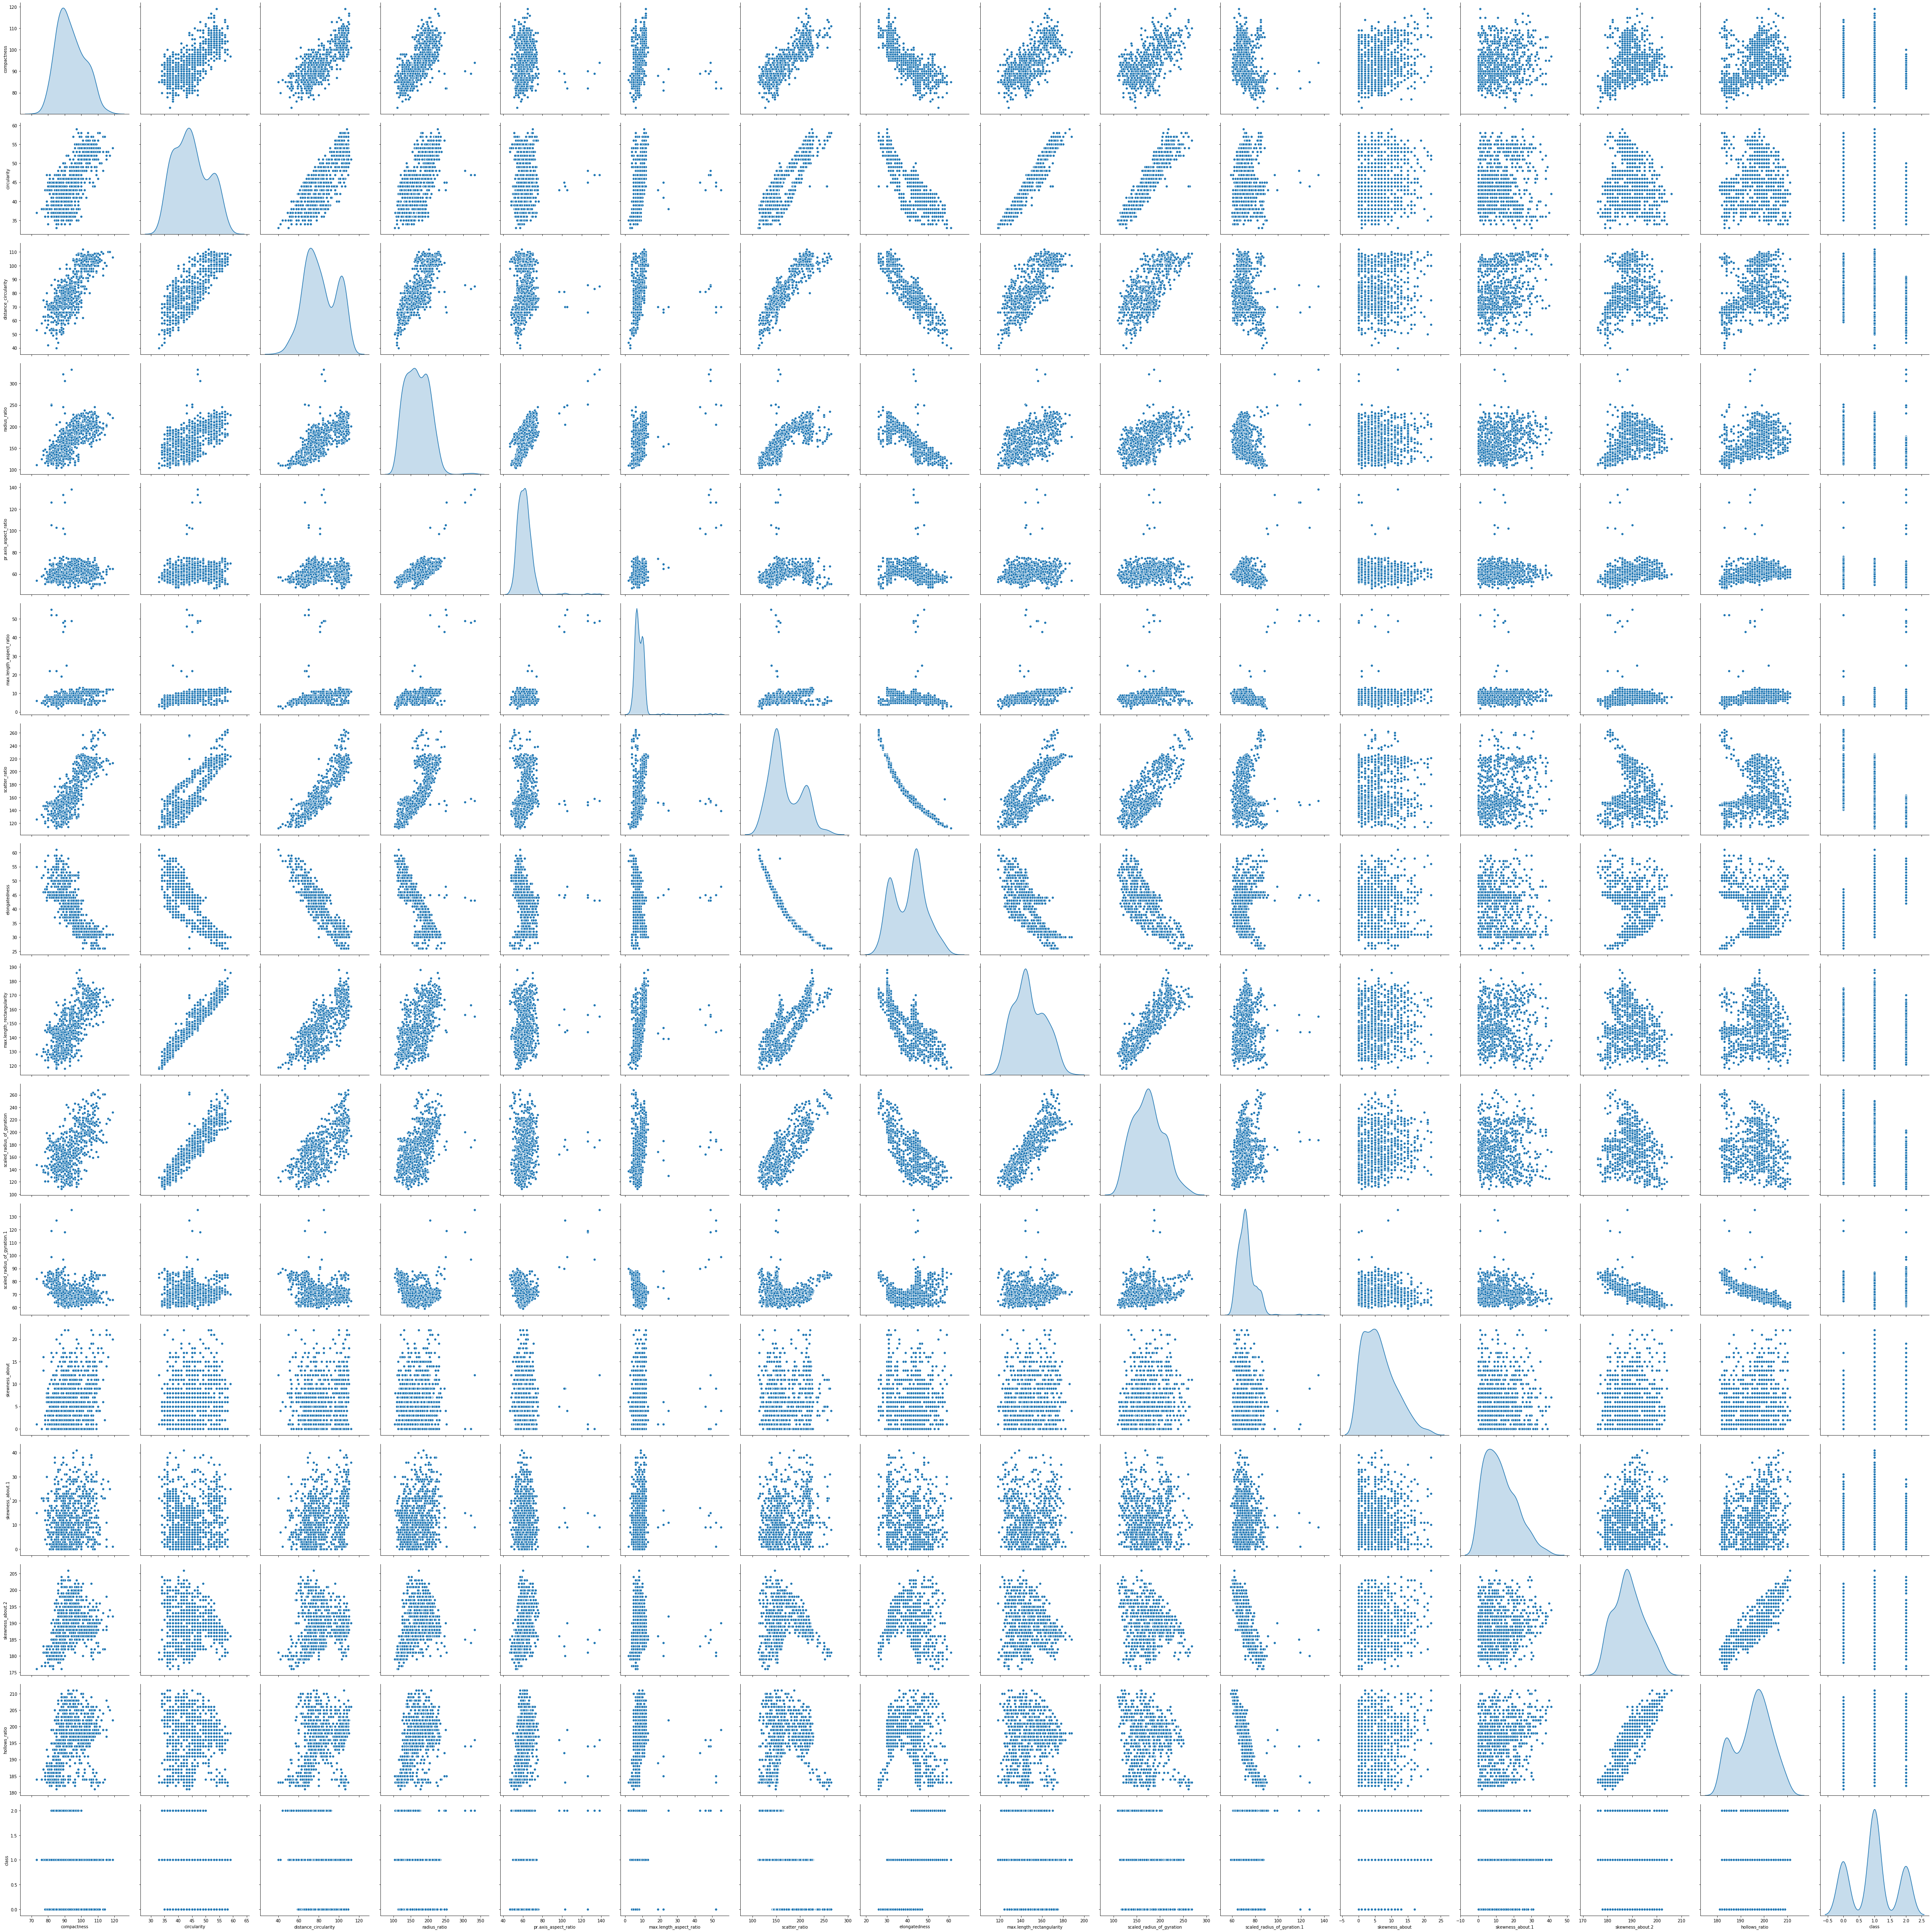

In [137]:
# draw pair plot which wil lhelp to get idea of covariance matrix 
sns.pairplot(data_copy,diag_kind='kde',size=4)

In [241]:
X=data_copy.drop('class',axis=1)
Y=data_copy['class']

In [242]:
# Lets scale our data
X_Scaled=X.apply(zscore)
X_Scaled.head()

compactness  circularity  distance_circularity  radius_ratio  \
0     0.160580     0.518073              0.057177      0.273363   
1    -0.325470    -0.623732              0.120741     -0.835032   
2     1.254193     0.844303              1.519141      1.202018   
3    -0.082445    -0.623732             -0.006386     -0.295813   
4    -1.054545    -0.134387             -0.769150      1.082192   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0              1.310398                 0.311542      -0.207598   
1             -0.593753                 0.094079      -0.599423   
2              0.548738                 0.311542       1.148719   
3              0.167907                 0.094079      -0.750125   
4              5.245643                 9.444962      -0.599423   

   elongatedness  max.length_rectangularity  scaled_radius_of_gyration  \
0       0.136262                   0.758332                   0.285705   
1       0.520519                  -0.344578                  -0.513630   
2      -1.144597                   0.689401                   1.392477   
3       0.648605                  -0.344578                  -1.466683   
4       0.520519                  -0.275646                   0.408680   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                    -0.327326       -0.073812          0.380870   
1                    -0.059384        0.538390          0.156798   
2                     0.074587        1.558727         -0.403383   
3                    -1.265121       -0.073812         -0.291347   
4                     7.309005        0.538390         -0.179311   

   skewness_about.2  hollows_ratio  
0         -0.312012       0.183957  
1          0.013265       0.452977  
2         -0.149374       0.049447  
3          1.639649       1.529056  
4         -1.450481      -1.699181

## Split the data into train and test

In [262]:
def get_SVM_Accuracy(X):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)
    model = SVC()
    start_time = time.time() 
    model.fit(X_train, y_train)
    elapsed_time = time.time() - start_time
    return model.score(X_train,y_train)*100,model.score(X_test,y_test)*100,elapsed_time

## Train a Support vector machine

In [263]:
Before_PCA_train_acc,Before_PCA_test_acc,time_taken = get_SVM_Accuracy(X_Scaled)
print(Before_PCA_train_acc)
print(Before_PCA_test_acc)
print(time_taken)

97.46621621621621
95.2755905511811
0.023352622985839844


In [264]:
data_copy.shape

(846, 16)

## Perform K-fold cross validation

In [278]:
#Apply k fold cross validation
#using default genral practice 10 kfolds

In [274]:
# Common k fold function
def get_kFold_Results(X):
    Y = data_copy['class']
    num_folds = 10
    seed = 7
    kfold = KFold(n_splits=num_folds, random_state=seed)
    model = SVC()
    results = cross_val_score(model, X, Y, cv=kfold)
    print(results)
    print("Accuracy: %.2f%% (%.2f%%)" % (results.mean()*100.0, results.std()*100.0))
    return results

In [247]:
data_copy.head()

compactness  circularity  distance_circularity  radius_ratio  \
0         95.0         48.0                  83.0         178.0   
1         91.0         41.0                  84.0         141.0   
2        104.0         50.0                 106.0         209.0   
3         93.0         41.0                  82.0         159.0   
4         85.0         44.0                  70.0         205.0   

   pr.axis_aspect_ratio  max.length_aspect_ratio  scatter_ratio  \
0                  72.0                     10.0          162.0   
1                  57.0                      9.0          149.0   
2                  66.0                     10.0          207.0   
3                  63.0                      9.0          144.0   
4                 103.0                     52.0          149.0   

   elongatedness  max.length_rectangularity  scaled_radius_of_gyration  \
0           42.0                      159.0                      184.0   
1           45.0                      143.0                      158.0   
2           32.0                      158.0                      220.0   
3           46.0                      143.0                      127.0   
4           45.0                      144.0                      188.0   

   scaled_radius_of_gyration.1  skewness_about  skewness_about.1  \
0                         70.0             6.0              16.0   
1                         72.0             9.0              14.0   
2                         73.0            14.0               9.0   
3                         63.0             6.0              10.0   
4                        127.0             9.0              11.0   

   skewness_about.2  hollows_ratio  class  
0             187.0          197.0    2.0  
1             189.0          199.0    2.0  
2             188.0          196.0    1.0  
3             199.0          207.0    2.0  
4             180.0          183.0    0.0

In [248]:
beforePCACV_results = get_kFold_Results(X_Scaled)

/home/arun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.94117647 0.97647059 0.95294118 0.97647059 0.97647059 0.97647059
 0.98809524 0.95238095 0.96428571 0.96428571]
Accuracy: 96.69% (1.38%)


## Use PCA from Scikit learn

In [249]:
#Apply PCA

In [250]:
covMatrix = np.cov(X_Scaled,rowvar=False)
print(covMatrix)

[[ 1.00118343  0.68569786  0.79086299  0.69055952  0.09164265  0.14842463
   0.81358214 -0.78968322  0.67694334  0.58593517 -0.24988794  0.23635777
   0.15720044  0.29889034  0.36598446]
 [ 0.68569786  1.00118343  0.79325751  0.6216467   0.15396023  0.25176438
   0.8489411  -0.82244387  0.96245572  0.92691166  0.05200785  0.14436828
  -0.01145212 -0.10455005  0.04640562]
 [ 0.79086299  0.79325751  1.00118343  0.76794246  0.15864319  0.26499957
   0.90614687 -0.9123854   0.77544391  0.70660663 -0.22621115  0.1140589
   0.26586088  0.14627113  0.33312625]
 [ 0.69055952  0.6216467   0.76794246  1.00118343  0.66423242  0.45058426
   0.73529816 -0.79041561  0.56962256  0.53700678 -0.18061084  0.04877032
   0.17394649  0.38266622  0.47186659]
 [ 0.09164265  0.15396023  0.15864319  0.66423242  1.00118343  0.64949139
   0.10385472 -0.18325156  0.1270594   0.12211524  0.15313091 -0.05843967
  -0.0320139   0.24016968  0.26804208]
 [ 0.14842463  0.25176438  0.26499957  0.45058426  0.64949139  1.0

In [251]:
pca = PCA()
pca.fit(X_Scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [252]:
# eigen value
print(pca.explained_variance_)

[6.73424898 2.96604006 1.84511574 1.13075964 0.91685774 0.47922479
 0.33870517 0.21907655 0.13915248 0.08734118 0.05882464 0.04160606
 0.02661545 0.02068772 0.01349527]


In [253]:
# eigen ratio
print(pca.explained_variance_ratio_)

[0.44841926 0.19750227 0.12286232 0.07529487 0.0610516  0.03191056
 0.02255365 0.01458784 0.00926587 0.00581586 0.00391701 0.00277046
 0.00177227 0.00137755 0.00089862]


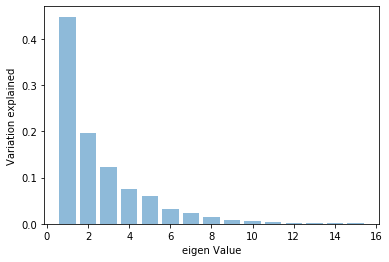

In [254]:
plt.bar(list(range(1,16)),pca.explained_variance_ratio_,alpha=0.5, align='center')
plt.ylabel('Variation explained')
plt.xlabel('eigen Value')
plt.show()

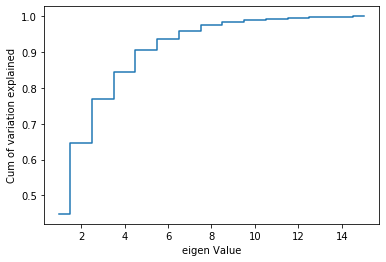

In [255]:
plt.step(list(range(1,16)),np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Cum of variation explained')
plt.xlabel('eigen Value')
plt.show()

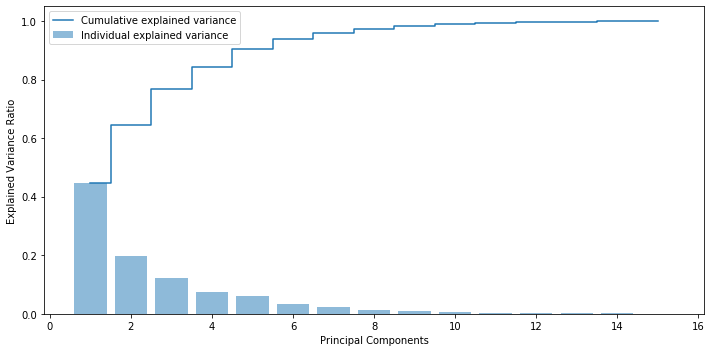

In [256]:
# Ploting 
plt.figure(figsize=(10 , 5))
plt.bar(range(1, pca.explained_variance_ratio_.size + 1), pca.explained_variance_ratio_, alpha = 0.5, align = 'center', label = 'Individual explained variance')
plt.step(range(1, pca.explained_variance_ratio_.size + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label = 'Cumulative explained variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc = 'best')
plt.tight_layout()
plt.show()

## Use 7 Principal components

In [258]:
pca7 = PCA(n_components=7)
pca7.fit(X_Scaled)
X_Scaled_PCA = pca7.transform(X_Scaled)

In [279]:
X_Scaled_PCA
After_PCA_train_acc,After_PCA_test_acc,time_taken = get_SVM_Accuracy(X_Scaled_PCA)
print(After_PCA_train_acc)
print(After_PCA_test_acc)
print(time_taken)

93.91891891891892
90.5511811023622
0.12399721145629883


## Compare the accuracy scores and cross validation scores

In [280]:
Before_PCA_train_acc,Before_PCA_test_acc,time_taken = get_SVM_Accuracy(X_Scaled)
print(Before_PCA_train_acc)
print(Before_PCA_test_acc)
print(time_taken)

97.46621621621621
95.2755905511811
0.032508134841918945


In [281]:
After_PCA_train_acc,After_PCA_test_acc,time_taken = get_SVM_Accuracy(X_Scaled_PCA)
print(After_PCA_train_acc)
print(After_PCA_test_acc)
print(time_taken)

93.91891891891892
90.5511811023622
0.4276390075683594


In [282]:
beforePCACV_results = get_kFold_Results(X_Scaled)

/home/arun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.94117647 0.97647059 0.95294118 0.97647059 0.97647059 0.97647059
 0.98809524 0.95238095 0.96428571 0.96428571]
Accuracy: 96.69% (1.38%)


In [283]:
afterPCACV_results = get_kFold_Results(X_Scaled_PCA)

/home/arun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


[0.94117647 0.91764706 0.91764706 0.90588235 0.91764706 0.95294118
 0.89285714 0.86904762 0.94047619 0.89285714]
Accuracy: 91.48% (2.44%)


In [284]:
# Summary:
# After PCA we can see drop in accuracy as we loose information(from attributes 6 to 7 Principal components)
# Although there is no significant gain in
# Computation time as well 
# before PCA time taken is 0.0267 
# After PCA tie taken in fitting the SVC model 0.0209
# with confidance interval of 95 % we can say that with using PCA acc 91.48% with std deviation 2.44% will range 
# from 86.6 to  96.36